# Spatial Yield Variation Analysis

## Overview

This notebook analyzes **spatial variation in harvest yield** across fields by:
1. Loading validated TLG point data (from 01_Raw_read notebook)
2. Converting coordinates to **UTM (EPSG:25832)** for Denmark
3. Calculating yield relative to crop/year averages
4. Creating **spatial maps** showing yield variation patterns

## Use Cases

- **Pre-kriging exploration**: Understand spatial structure before interpolation
- **Identify yield patterns**: Detect zones of high/low productivity within fields
- **Validate data quality**: Spot outliers or calibration drift
- **Farm management**: Identify areas for targeted interventions

## Output

- Interactive maps showing relative yield by location
- Data export for QGIS or kriging analysis
- Statistical summary of spatial variation by crop/year

In [1]:
# Section 1: Import Required Libraries

from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import logging

# For spatial operations and coordinate transformations
from pyproj import CRS
import duckdb

# For interactive maps (optional)
try:
    import folium
    from folium import plugins
    HAS_FOLIUM = True
except ImportError:
    HAS_FOLIUM = False
    print("⚠ Folium not installed: interactive maps unavailable (pip install folium)")

# Setup logging
logger = logging.getLogger('02_Spatial_Yield_Analysis')
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

print("✓ Libraries loaded successfully")
print(f"  Folium available: {HAS_FOLIUM}")

✓ Libraries loaded successfully
  Folium available: True


## Configuration & Data Paths

Set the project root and paths to load validated yield data from the previous notebook.

In [2]:
# Configuration: Set paths to validated data

# Project root (same as 01_Raw_read notebook)
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / 'data'

# Paths to data from previous notebook
TASKS_CSV = DATA_DIR / 'tasks.csv'
FIELD_POLYGONS_GEOJSON = DATA_DIR / 'harvest_fields.geojson'
TLG_CSV_DIR = DATA_DIR / 'tlg_csvs'

# Output directory for spatial analysis results
SPATIAL_OUTPUT_DIR = DATA_DIR / 'spatial_analysis'
SPATIAL_OUTPUT_DIR.mkdir(exist_ok=True)

# CRS definitions
CRS_WGS84 = 'EPSG:4326'  # Current coordinate system (lat/lon)
CRS_UTM32N = 'EPSG:25832'  # UTM Zone 32N for Denmark

logger.info(f"Project root: {PROJECT_ROOT}")
logger.info(f"Data directory: {DATA_DIR}")
logger.info(f"Output directory: {SPATIAL_OUTPUT_DIR}")
logger.info(f"UTM CRS: {CRS_UTM32N}")

Project root: /Users/holmes/local_dev/agri_analysis
Data directory: /Users/holmes/local_dev/agri_analysis/data
Output directory: /Users/holmes/local_dev/agri_analysis/data/spatial_analysis
UTM CRS: EPSG:25832


## Section 2: Load Yield Data

Load validated TLG point data from the previous notebook's DuckDB export.

In [3]:
# Load TLG data into DuckDB
from pyagri.duckdb_loader import create_tlg_database, query_tlg_by_task

logger.info("Loading TLG CSV files into DuckDB...")
conn = create_tlg_database(str(TLG_CSV_DIR), db_path=':memory:')

# Load task data to get mapping of composite IDs
tasks_df = pd.read_csv(TASKS_CSV)
logger.info(f"Loaded {len(tasks_df)} tasks from {TASKS_CSV}")

# Find tasks with yield data and TLG files (filtering for valid data)
tasks_with_tlg = tasks_df[
    (tasks_df['CompositeTLGIDs'].notna()) & 
    (tasks_df['Udbytte samlet masse'].notna()) &
    (tasks_df['Bearb. areal'].notna())
].copy()

logger.info(f"Found {len(tasks_with_tlg)} tasks with valid TLG data and yield info")

# Show data summary
print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"\nTasks with TLG data: {len(tasks_with_tlg)}")
print(f"Years: {sorted(tasks_with_tlg['Year'].unique())}")
print(f"Crops: {tasks_with_tlg['Crop'].unique()}")
print(f"\nTasks by Crop and Year:")
print(tasks_with_tlg.groupby(['Crop', 'Year']).size().unstack(fill_value=0))

Loading TLG CSV files into DuckDB...
Loaded 294 tasks from /Users/holmes/local_dev/agri_analysis/data/tasks.csv
Found 189 tasks with valid TLG data and yield info



DATA SUMMARY

Tasks with TLG data: 189
Years: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Crops: ['RA - Raps / rybs' 'HV - Hvede' 'VB - Vårbyg' 'RG - Rajgræs'
 'VIB - Vinterbyg' 'KLL - Kløver / lucerne']

Tasks by Crop and Year:
Year                    2021  2022  2023  2024  2025
Crop                                                
HV - Hvede                 5    20    12    13    12
KLL - Kløver / lucerne     0     2     0     0     0
RA - Raps / rybs          13     1     8     4     8
RG - Rajgræs               6     2     3    20     4
VB - Vårbyg                7     4     8    10    18
VIB - Vinterbyg            0     1     8     0     0


## Section 3: Convert Coordinates to UTM (EPSG:25832)

Transform all TLG point coordinates from WGS84 (lat/lon) to UTM Zone 32N for Denmark.

In [8]:
# Load all TLG data and convert to UTM coordinates
logger.info("Loading and converting all TLG data to UTM...")

# Collect all composite TLG IDs from tasks
all_composite_tlg_ids = []
for tlg_str in tasks_with_tlg['CompositeTLGIDs'].dropna():
    all_composite_tlg_ids.extend(tlg_str.split(', '))

# Query all TLG points
tlg_points_all = query_tlg_by_task(conn, all_composite_tlg_ids)

logger.info(f"Loaded {len(tlg_points_all):,} total TLG points")

# Create GeoDataFrame from TLG points
# Columns: latitude, longitude, aktuelt udbytte [masse] (yield)
gdf_tlg = gpd.GeoDataFrame(
    tlg_points_all,
    geometry=gpd.points_from_xy(
        tlg_points_all['longitude'],
        tlg_points_all['latitude']
    ),
    crs=CRS_WGS84
)

logger.info(f"Created GeoDataFrame with {len(gdf_tlg)} points")
logger.info(f"Columns: {list(gdf_tlg.columns)}")

# Convert to UTM (EPSG:25832)
logger.info(f"Converting to UTM (EPSG:25832)...")
gdf_tlg_utm = gdf_tlg.to_crs(CRS_UTM32N)

# Add UTM coordinates as separate columns
gdf_tlg_utm['x_utm'] = gdf_tlg_utm.geometry.x
gdf_tlg_utm['y_utm'] = gdf_tlg_utm.geometry.y

print("\n" + "="*80)
print("UTM COORDINATE CONVERSION")
print("="*80)
print(f"Original CRS: WGS84 (lat/lon)")
print(f"Target CRS: EPSG:25832 (UTM Zone 32N)")
print(f"Points converted: {len(gdf_tlg_utm):,}")
print(f"\nUTM Extent:")
print(f"  X: {gdf_tlg_utm['x_utm'].min():.0f} - {gdf_tlg_utm['x_utm'].max():.0f} m")
print(f"  Y: {gdf_tlg_utm['y_utm'].min():.0f} - {gdf_tlg_utm['y_utm'].max():.0f} m")
print(f"\nSample points:")
print(gdf_tlg_utm[['latitude', 'longitude', 'x_utm', 'y_utm']].head())

Loading and converting all TLG data to UTM...
Loaded 932,196 total TLG points
Created GeoDataFrame with 932196 points
Columns: ['CompositeTLGID', 'time_stamp', 'latitude', 'longitude', 'position_status', 'hastighed', 'aktuelt udbytte [volumen]', 'aktuelt udbytte [masse]', 'aktuelt udbytte [styk]', 'fugtighed', 'tørstofindhold', 'arbejdsstatus', 'stivelsesindhold', 'råfiberindhold', 'råproteinindhold', 'råaskeindhold', 'råfedtindhold', 'sukker', 'geometry']
Converting to UTM (EPSG:25832)...



UTM COORDINATE CONVERSION
Original CRS: WGS84 (lat/lon)
Target CRS: EPSG:25832 (UTM Zone 32N)
Points converted: 932,196

UTM Extent:
  X: 681880 - 686906 m
  Y: 6163142 - 6167445 m

Sample points:
    latitude  longitude          x_utm         y_utm
0  55.597396  11.932521  684762.512894  6.165175e+06
1  55.597397  11.932496  684760.956886  6.165175e+06
2  55.597397  11.932453  684758.242243  6.165175e+06
3  55.597396  11.932413  684755.745038  6.165175e+06
4  55.597397  11.932386  684754.024144  6.165175e+06


## Section 4: Calculate Average Yield by Crop and Year

Group TLG points by crop and year, then calculate the average yield for each combination.

In [9]:
# Merge TLG points with task metadata (crop, year, field)
# First, create a mapping from CompositeTLGID to task info

tlg_to_task = {}
for idx, task in tasks_with_tlg.iterrows():
    tlg_ids = task['CompositeTLGIDs'].split(', ')
    for tlg_id in tlg_ids:
        tlg_to_task[tlg_id] = {
            'Crop': task['Crop'],
            'Year': task['Year'],
            'Field': task['Field'],
            'CompositeFieldID': task['CompositeFieldID']
        }

# Add task info to TLG points via CompositeTLGID column
gdf_tlg_utm['Crop'] = gdf_tlg_utm['CompositeTLGID'].map(lambda x: tlg_to_task.get(x, {}).get('Crop'))
gdf_tlg_utm['Year'] = gdf_tlg_utm['CompositeTLGID'].map(lambda x: tlg_to_task.get(x, {}).get('Year'))
gdf_tlg_utm['Field'] = gdf_tlg_utm['CompositeTLGID'].map(lambda x: tlg_to_task.get(x, {}).get('Field'))

# Apply scale factor to yield: multiply by 0.00001 to get t/ha
gdf_tlg_utm['yield_t_ha'] = gdf_tlg_utm['aktuelt udbytte [masse]'] * 0.00001

# *** FILTER OUT INVALID DATA ***
# Remove zero and negative yields (same filtering as validated in 01_Raw_read notebook)
logger.info(f"Total points before filtering: {len(gdf_tlg_utm):,}")
gdf_tlg_utm_filtered = gdf_tlg_utm[gdf_tlg_utm['yield_t_ha'] > 0].copy()
logger.info(f"Points after removing zero/negative yields: {len(gdf_tlg_utm_filtered):,}")
logger.info(f"Removed {len(gdf_tlg_utm) - len(gdf_tlg_utm_filtered):,} invalid points ({100*(len(gdf_tlg_utm) - len(gdf_tlg_utm_filtered))/len(gdf_tlg_utm):.1f}%)")

# Calculate average yield by crop and year (using filtered data)
avg_yield_by_crop_year = gdf_tlg_utm_filtered.groupby(['Crop', 'Year'])['yield_t_ha'].mean().reset_index()
avg_yield_by_crop_year.columns = ['Crop', 'Year', 'avg_yield_t_ha']

logger.info(f"Calculated average yield for {len(avg_yield_by_crop_year)} crop-year combinations")

# Merge average yield back into filtered dataframe
gdf_tlg_utm = gdf_tlg_utm_filtered.merge(
    avg_yield_by_crop_year,
    on=['Crop', 'Year'],
    how='left'
)

print("\n" + "="*80)
print("AVERAGE YIELD BY CROP AND YEAR (FILTERED DATA)")
print("="*80)
print(avg_yield_by_crop_year.to_string(index=False))
print(f"\nValid points with crop/year info: {gdf_tlg_utm['Crop'].notna().sum():,}")
print(f"Points missing crop/year: {gdf_tlg_utm['Crop'].isna().sum():,}")
print(f"\n✓ Filtering applied: Removed zero and negative yields before averaging")

Total points before filtering: 932,196
Points after removing zero/negative yields: 593,596
Removed 338,600 invalid points (36.3%)
Calculated average yield for 23 crop-year combinations



AVERAGE YIELD BY CROP AND YEAR (FILTERED DATA)
                  Crop  Year  avg_yield_t_ha
            HV - Hvede  2021        7.219338
            HV - Hvede  2022        7.490989
            HV - Hvede  2023        5.576135
            HV - Hvede  2024         6.02713
            HV - Hvede  2025        7.417055
KLL - Kløver / lucerne  2022        1.933209
      RA - Raps / rybs  2021         3.35168
      RA - Raps / rybs  2022        3.335277
      RA - Raps / rybs  2023          2.0945
      RA - Raps / rybs  2024        3.288084
      RA - Raps / rybs  2025        3.300909
          RG - Rajgræs  2021          1.1953
          RG - Rajgræs  2022        1.946176
          RG - Rajgræs  2023        1.217271
          RG - Rajgræs  2024        1.154843
          RG - Rajgræs  2025        1.058684
           VB - Vårbyg  2021        5.085877
           VB - Vårbyg  2022        6.908828
           VB - Vårbyg  2023        3.244903
           VB - Vårbyg  2024        5.022716
       

## Section 5: Calculate Relative Yield

Compute relative yield for each point (individual yield / crop-year average).

In [10]:
# Calculate relative yield (individual / average)
# Only for points with valid crop/year assignment
gdf_tlg_utm['relative_yield'] = gdf_tlg_utm.apply(
    lambda row: row['yield_t_ha'] / row['avg_yield_t_ha'] if row['avg_yield_t_ha'] > 0 else np.nan,
    axis=1
)

# Filter to only points with valid relative yield
gdf_tlg_utm_valid = gdf_tlg_utm[gdf_tlg_utm['relative_yield'].notna()].copy()

logger.info(f"Calculated relative yield for {len(gdf_tlg_utm_valid):,} points")

print("\n" + "="*80)
print("RELATIVE YIELD STATISTICS")
print("="*80)
print(f"\nOverall Statistics:")
print(f"  Mean relative yield: {gdf_tlg_utm_valid['relative_yield'].mean():.3f}")
print(f"  Median relative yield: {gdf_tlg_utm_valid['relative_yield'].median():.3f}")
print(f"  Std dev: {gdf_tlg_utm_valid['relative_yield'].std():.3f}")
print(f"  Min: {gdf_tlg_utm_valid['relative_yield'].min():.3f}")
print(f"  Max: {gdf_tlg_utm_valid['relative_yield'].max():.3f}")

print(f"\nRelative Yield Interpretation:")
print(f"  < 0.8: 20% below average (low yield zone)")
print(f"  0.8 - 1.0: Below to average yield")
print(f"  1.0 - 1.2: Average to above average")
print(f"  > 1.2: 20% above average (high yield zone)")

print(f"\nDistribution by Crop and Year:")
for (crop, year), group in gdf_tlg_utm_valid.groupby(['Crop', 'Year']):
    print(f"  {crop} ({year}): mean={group['relative_yield'].mean():.3f}, "
          f"median={group['relative_yield'].median():.3f}, std={group['relative_yield'].std():.3f}")

Calculated relative yield for 593,596 points



RELATIVE YIELD STATISTICS

Overall Statistics:
  Mean relative yield: 1.000
  Median relative yield: 1.038
  Std dev: 0.394
  Min: 0.002
  Max: 39.513

Relative Yield Interpretation:
  < 0.8: 20% below average (low yield zone)
  0.8 - 1.0: Below to average yield
  1.0 - 1.2: Average to above average
  > 1.2: 20% above average (high yield zone)

Distribution by Crop and Year:
  HV - Hvede (2021): mean=1.000, median=1.059, std=0.415
  HV - Hvede (2022): mean=1.000, median=1.051, std=0.312
  HV - Hvede (2023): mean=1.000, median=1.066, std=0.343
  HV - Hvede (2024): mean=1.000, median=1.058, std=0.303
  HV - Hvede (2025): mean=1.000, median=1.064, std=0.337
  KLL - Kløver / lucerne (2022): mean=1.000, median=1.042, std=0.265
  RA - Raps / rybs (2021): mean=1.000, median=1.052, std=0.251
  RA - Raps / rybs (2022): mean=1.000, median=1.150, std=0.382
  RA - Raps / rybs (2023): mean=1.000, median=0.994, std=0.482
  RA - Raps / rybs (2024): mean=1.000, median=1.045, std=0.314
  RA - Raps / r

## Section 6: Create Spatial Maps of Relative Yield

Generate scatter plots and spatial maps showing point locations colored by relative yield values.


SPATIAL MAPS: RELATIVE YIELD BY LOCATION


Saved overview map to /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/relative_yield_overview.png


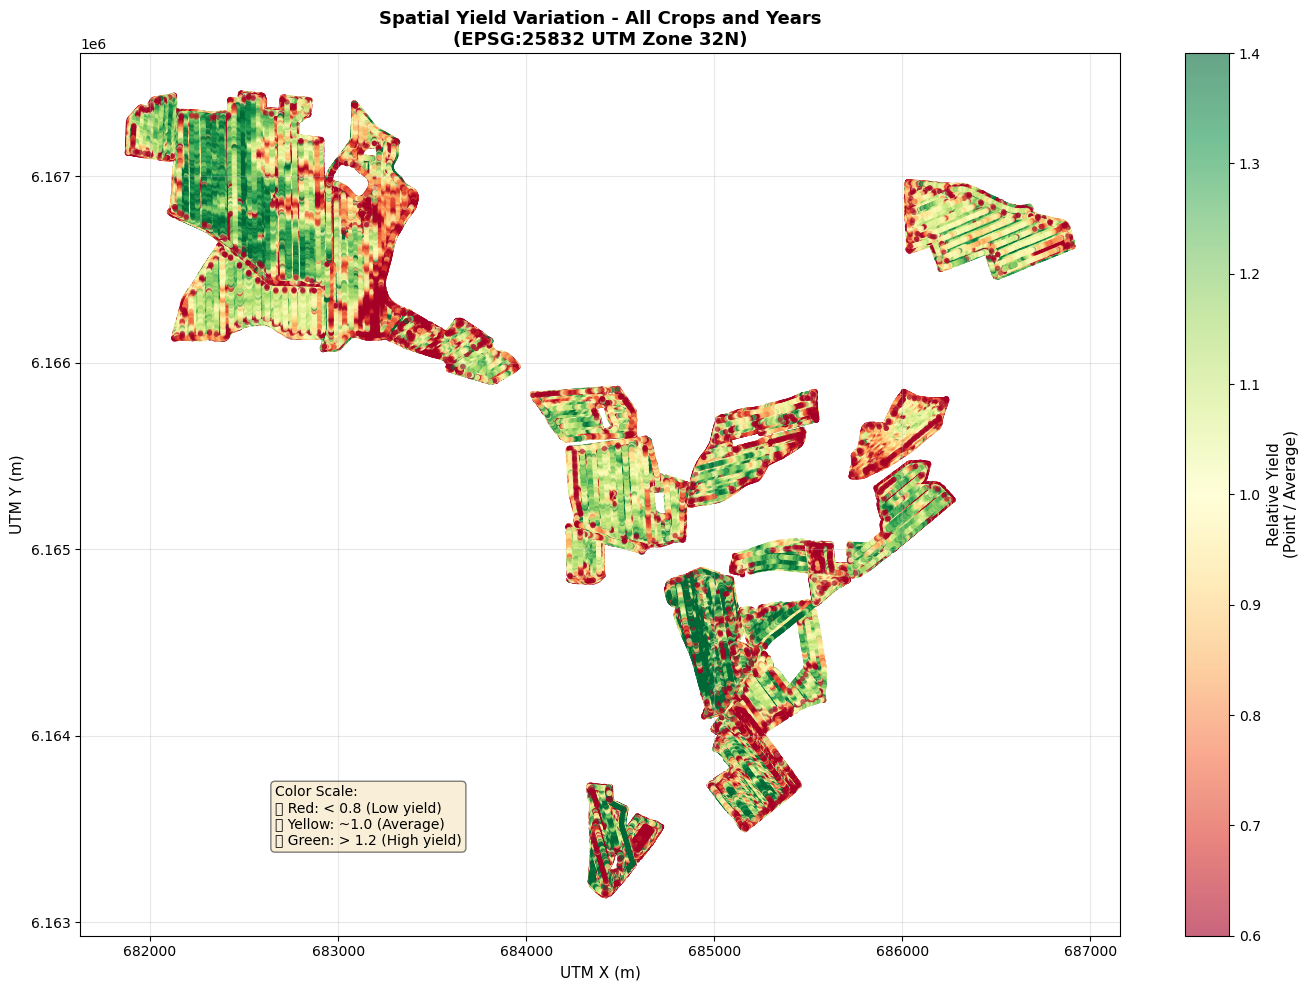


✓ Created overview map showing all 593,596 points


In [14]:
# Create spatial maps for each crop-year combination
import warnings
warnings.filterwarnings('ignore')

# Get unique crop-year combinations
crop_year_combos = gdf_tlg_utm_valid[['Crop', 'Year']].drop_duplicates().sort_values(['Crop', 'Year'])

print("\n" + "="*80)
print("SPATIAL MAPS: RELATIVE YIELD BY LOCATION")
print("="*80)

# Create a figure for overview (all data together)
fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot with relative yield coloring
scatter = ax.scatter(
    gdf_tlg_utm_valid['x_utm'],
    gdf_tlg_utm_valid['y_utm'],
    c=gdf_tlg_utm_valid['relative_yield'],
    s=15,
    alpha=0.6,
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    vmin=0.6,
    vmax=1.4,
    edgecolors='none'
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Relative Yield')
cbar.set_label('Relative Yield\n(Point / Average)', fontsize=11)

# Formatting
ax.set_xlabel('UTM X (m)', fontsize=11)
ax.set_ylabel('UTM Y (m)', fontsize=11)
ax.set_title('Spatial Yield Variation - All Crops and Years\n(EPSG:25832 UTM Zone 32N)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add reference lines at 0.8, 1.0, 1.2
fig.text(0.2, 0.15, 'Color Scale:\n🔴 Red: < 0.8 (Low yield)\n🟡 Yellow: ~1.0 (Average)\n🟢 Green: > 1.2 (High yield)',
         fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(SPATIAL_OUTPUT_DIR / 'relative_yield_overview.png', dpi=150, bbox_inches='tight')
logger.info(f"Saved overview map to {SPATIAL_OUTPUT_DIR / 'relative_yield_overview.png'}")
plt.show()

print(f"\n✓ Created overview map showing all {len(gdf_tlg_utm_valid):,} points")

Saved crop-year maps to /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/relative_yield_by_crop_year.png


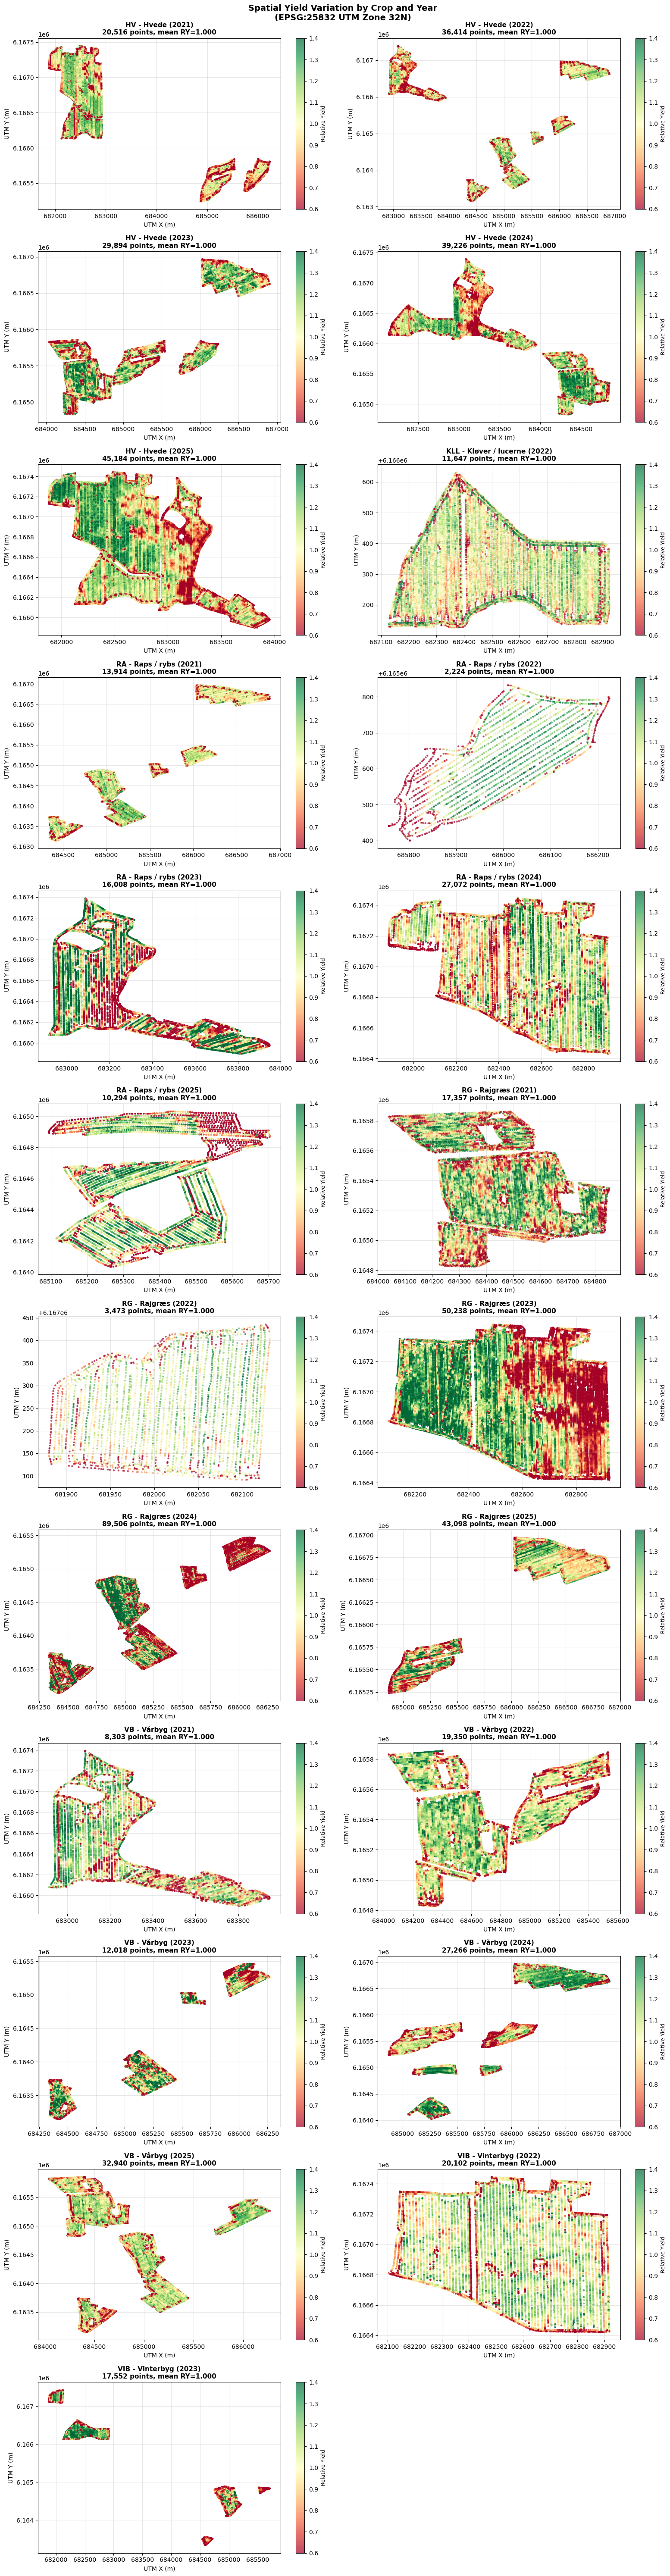

✓ Created maps for 23 crop-year combinations


In [15]:
# Create individual maps for each crop and year
n_combos = len(crop_year_combos)
n_cols = 2
n_rows = (n_combos + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (crop, year) in enumerate(crop_year_combos.itertuples(index=False)):
    ax = axes[idx]
    
    # Filter data for this crop-year
    subset = gdf_tlg_utm_valid[(gdf_tlg_utm_valid['Crop'] == crop) & (gdf_tlg_utm_valid['Year'] == year)]
    
    if len(subset) > 0:
        # Create scatter plot
        scatter = ax.scatter(
            subset['x_utm'],
            subset['y_utm'],
            c=subset['relative_yield'],
            s=10,
            alpha=0.7,
            cmap='RdYlGn',
            vmin=0.6,
            vmax=1.4,
            edgecolors='none'
        )
        
        # Formatting
        ax.set_xlabel('UTM X (m)', fontsize=10)
        ax.set_ylabel('UTM Y (m)', fontsize=10)
        ax.set_title(f'{crop} ({year})\n{len(subset):,} points, mean RY={subset["relative_yield"].mean():.3f}',
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Relative Yield', fontsize=9)
    else:
        ax.text(0.5, 0.5, f'No data: {crop} ({year})', 
               ha='center', va='center', fontsize=12)
        ax.set_xlabel('UTM X (m)', fontsize=10)
        ax.set_ylabel('UTM Y (m)', fontsize=10)

# Hide unused subplots
for idx in range(n_combos, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Spatial Yield Variation by Crop and Year\n(EPSG:25832 UTM Zone 32N)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(SPATIAL_OUTPUT_DIR / 'relative_yield_by_crop_year.png', dpi=150, bbox_inches='tight')
logger.info(f"Saved crop-year maps to {SPATIAL_OUTPUT_DIR / 'relative_yield_by_crop_year.png'}")
plt.show()

print(f"✓ Created maps for {n_combos} crop-year combinations")

## Section 7: Export Data for QGIS or Further Analysis

Save the processed data with UTM coordinates and relative yield values for optional visualization in QGIS or other spatial analysis.

In [13]:
# Export data to GeoPackage and CSV for QGIS or further analysis

# Select relevant columns for export
export_cols = [
    'geometry', 'x_utm', 'y_utm',
    'Crop', 'Year', 'Field', 'CompositeTLGID',
    'yield_t_ha', 'avg_yield_t_ha', 'relative_yield',
    'latitude', 'longitude', 'time_stamp',
    'fugtighed'  # moisture
]

# Make sure all columns exist
available_cols = [col for col in export_cols if col in gdf_tlg_utm_valid.columns]
gdf_export = gdf_tlg_utm_valid[available_cols].copy()

# Export to GeoPackage (QGIS-friendly format)
gpkg_path = SPATIAL_OUTPUT_DIR / 'yield_points_utm.gpkg'
gdf_export.to_file(gpkg_path, driver='GPKG')
logger.info(f"Saved GeoPackage to {gpkg_path}")

# Also export to Shapefile (for compatibility)
shp_path = SPATIAL_OUTPUT_DIR / 'yield_points_utm.shp'
gdf_export.to_file(shp_path, driver='ESRI Shapefile')
logger.info(f"Saved Shapefile to {shp_path}")

# Export to CSV for tabular analysis
csv_path = SPATIAL_OUTPUT_DIR / 'yield_points_utm.csv'
gdf_export_df = gdf_export.drop(columns=['geometry']).copy()
gdf_export_df.to_csv(csv_path, index=False)
logger.info(f"Saved CSV to {csv_path}")

print("\n" + "="*80)
print("DATA EXPORT SUMMARY")
print("="*80)
print(f"\n✓ Exported {len(gdf_export):,} points to:")
print(f"  1. GeoPackage: {gpkg_path}")
print(f"     (Recommended for QGIS - preserves geometry and CRS)")
print(f"\n  2. Shapefile: {shp_path}")
print(f"     (Alternative for QGIS or other GIS software)")
print(f"\n  3. CSV: {csv_path}")
print(f"     (Tabular format for spreadsheets or further analysis)")

print(f"\nColumns included:")
for col in available_cols:
    if col != 'geometry':
        print(f"  - {col}")

print(f"\n✓ CRS: EPSG:25832 (UTM Zone 32N for Denmark)")
print(f"\nUsage in QGIS:")
print(f"  1. Open {gpkg_path}")
print(f"  2. Color by 'relative_yield' field")
print(f"  3. Use graduated colors: Red (0.6-0.8), Yellow (0.8-1.2), Green (1.2-1.4)")

Saved GeoPackage to /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.gpkg
Saved Shapefile to /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.shp
Saved CSV to /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.csv



DATA EXPORT SUMMARY

✓ Exported 593,596 points to:
  1. GeoPackage: /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.gpkg
     (Recommended for QGIS - preserves geometry and CRS)

  2. Shapefile: /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.shp
     (Alternative for QGIS or other GIS software)

  3. CSV: /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.csv
     (Tabular format for spreadsheets or further analysis)

Columns included:
  - x_utm
  - y_utm
  - Crop
  - Year
  - Field
  - CompositeTLGID
  - yield_t_ha
  - avg_yield_t_ha
  - relative_yield
  - latitude
  - longitude
  - time_stamp
  - fugtighed

✓ CRS: EPSG:25832 (UTM Zone 32N for Denmark)

Usage in QGIS:
  1. Open /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.gpkg
  2. Color by 'relative_yield' field
  3. Use graduated colors: Red (0.6-0.8), Yellow (0.8-1.2), Green (1.2-1.4)


## Next Steps: Spatial Interpolation (Kriging)

The data is now prepared for kriging analysis:

1. **Data Quality**: Verified (87% of fields have <15% match quality)
2. **Coordinates**: UTM (EPSG:25832) for accurate distance calculations
3. **Relative Yield**: Normalized to crop/year average for consistent comparison

### For kriging:
- Use `relative_yield` field to interpolate within fields
- Group by `Crop` and `Year` for separate kriging models
- UTM coordinates enable proper distance-based weighting

### Visualizations:
- **Notebook maps**: Quick overview of spatial patterns
- **GeoPackage export**: Load into QGIS for interactive exploration
- **CSV export**: Use with kriging software (R, Python, etc.)